In [502]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from PIL import Image
from scipy.integrate import odeint

# 1. SIR model

https://pub.towardsai.net/graphing-the-sir-model-with-python-e3cd6edb20de

In [503]:
a = 1
b = 0.1

In [505]:
# FUNCTION TO RETURN DERIVATIVES AT T
def f(y, t):
    S, I, R = y 
    d0 = -a * S * I # derivative of S(t)
    d1 = a * S * I - b * I # derivative of I(t)
    d2 = b * I # derivative of R(t)
    return [d0, d1, d2]

In [ ]:
# S, I, R = y
# # or
# S = y[0]
# I = y[1]
# R = y[2]

In [506]:
S_0 = 1
I_0 = 50/109_581_078
R_0 = 0

In [507]:
y_0 = [S_0,I_0,R_0]

In [508]:
t = np.linspace(start=1,stop=100,num=100)

In [509]:
y = odeint(f,y_0,t)

In [510]:
S = y[:,0]
I = y[:,1]
R = y[:,2]

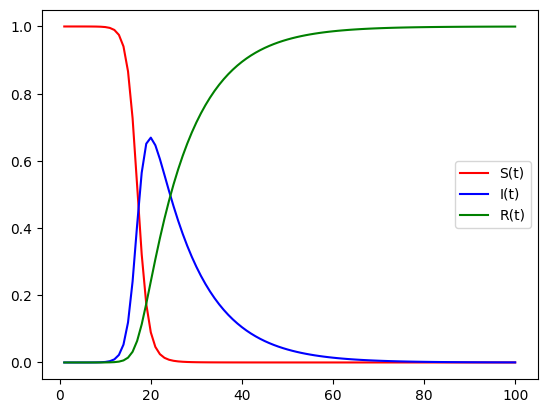

In [512]:
plt.plot(t,S,'r',label='S(t)')
plt.plot(t,I,'b',label='I(t)')
plt.plot(t,R,'g',label='R(t)')
plt.legend()
plt.show()

# 2. SIR model on a network

In [120]:
def sir_netw(G, p, origin = None, with_nodes = False):
    """
#    Single run of the SIR model on network.
    """
    
    N = len(G)
    infected = []
    
    # initialize nodes
    for node in G.nodes():
        G.nodes[node]["state"] = "S" # all healthy at the beginning

    #inject the 'zero' patient randomly if we do not have given one
    if origin == None:
        node = random.choice(list(G.nodes))
        G.nodes[node]["state"] = "I"
        infected = [node]
    else:
        G.nodes[origin]["state"] = "I"
        infected = [origin]
    
    if with_nodes:
        results = [[N - 1, 1, 0, G.copy().nodes]]
    else:
        results = [[N - 1, 1, 0]]
    
    #time loop while number of infected is not equal 0
    while results[-1][1] != 0:
        new_infected = []
        ns = results[-1][0]
        ni = results[-1][1]
        nr = results[-1][2]
        
        for node in infected:
            for neigh in G.neighbors(node):
                if G.nodes[neigh]["state"] == "S":
                    q = random.random()
                    if q < p:
                        G.nodes[neigh]["state"] = "I"
                        new_infected.append(neigh)
                        ns -= 1
                        ni += 1
            G.nodes[node]["state"] = "R"
            ni -= 1
            nr += 1
        if with_nodes:
            results.append([ns, ni, nr, G.copy().nodes])
        else:
            results.append([ns, ni, nr])
        infected = new_infected
    return results

## a. Simulate the model on graph with 100 nodes

I chose probability $p = 0.3$

In [121]:
q = 0.3

### 2D lattice graph

In [122]:
a = 10
b = 10
G_2d_lat = nx.grid_2d_graph(a, b)

result_2d_lat = sir_netw(G_2d_lat, q)
last_res = result_2d_lat[-1]
print(f"Number of susceptible: {last_res[0]}, infected: {last_res[1]}, removed: {last_res[2]}")

Number of susceptible: 87, infected: 0, removed: 13


### Random graph

In [123]:
numb_nodes = 100
p = 0.5
G_rand = nx.erdos_renyi_graph(numb_nodes, p)

result_rand = sir_netw(G_rand, q)
last_res = result_rand[-1]
print(f"Number of susceptible: {last_res[0]}, infected: {last_res[1]}, removed: {last_res[2]}")

Number of susceptible: 0, infected: 0, removed: 100


### Watts–Strogatz graph

In [124]:
numb_nodes = 100
k = 4
p = 0.7
G_ws = nx.watts_strogatz_graph(numb_nodes, k, p)

result_ws = sir_netw(G_ws, q)
last_res = result_ws[-1]
print(f"Number of susceptible: {last_res[0]}, infected: {last_res[1]}, removed: {last_res[2]}")

Number of susceptible: 74, infected: 0, removed: 26


### Barabási–Albert graph

In [125]:
numb_nodes = 100
m = 4
G_ba = nx.barabasi_albert_graph(numb_nodes, m)

q = 0.3
result_ba = sir_netw(G_ba, q)
last_res = result_ba[-1]
print(f"Number of susceptible: {last_res[0]}, infected: {last_res[1]}, removed: {last_res[2]}")

Number of susceptible: 14, infected: 0, removed: 86


## b. The fraction of infected nodes

In [310]:
def fraction_time(G, p, N):
    all_average = []
    origin = random.choice(list(G.nodes))
    for q in p:
        average = list(np.divide(sir_netw(G, q, origin), len(G.nodes)))
        for i in range(N - 1):
            result = sir_netw(G, q, origin)
            n1 = len(average)
            n2 = len(result)
            if n1 < n2:
                for j in range(n2 - n1):
                    average.append(average[-1])
            elif n1 > n2:
                for j in range(n1 - n2):
                    result.append(result[-1])
            result = list(np.divide(result, len(G.nodes)))
            average = list(np.add(average, result))
        average = np.divide(average, N)
        all_average.append(average)
    return all_average

In [311]:
def plot_frac(all_average, p):
    n = len(p)
    
    fig, axes = plt.subplots(1, n, figsize = (5*n, 5))
    fig.suptitle("Plot of the average of the fraction of infected nodes")
    
    for i, q in enumerate(p):
        av = np.array(all_average[i])
        t = np.arange(len(av))
        axes[i].plot(t, av[:, 0], label = "Susceptible", color = "g")
        axes[i].plot(t, av[:, 1], label = "Infected", color = "r")
        axes[i].plot(t, av[:, 2], label = "Removed", color = "b")
        axes[i].legend()
        axes[i].set(xlabel = 'Time', ylabel = 'Fraction of nodes')
        axes[i].set_title(f"p = {q}")
    plt.show()

In [312]:
q = [0.3, 0.5, 0.7]
N = 1000

### 2D lattice graph

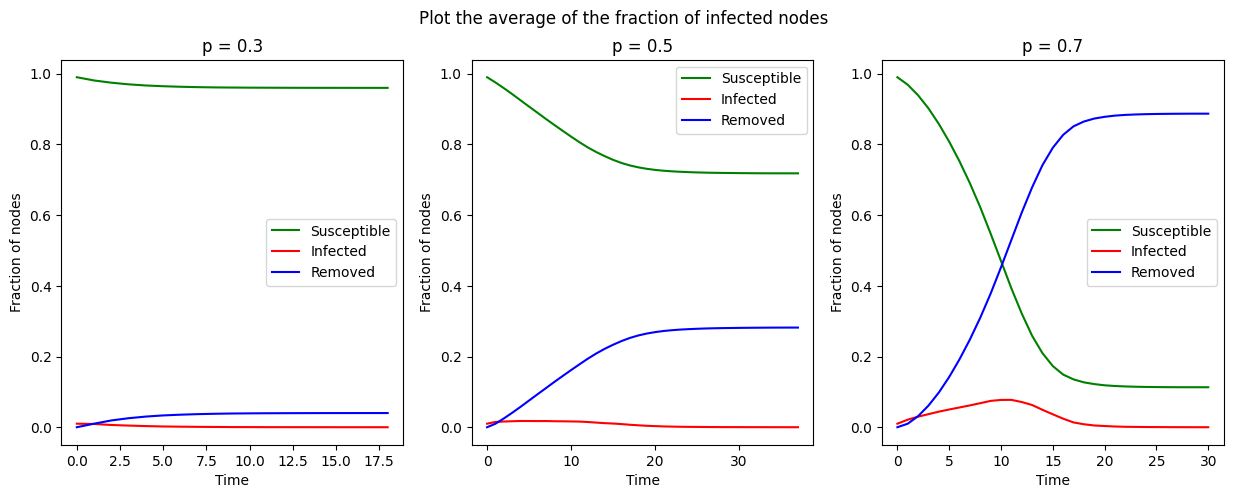

In [313]:
a = 10
b = 10
G_2d_lat = nx.grid_2d_graph(a, b)

frac_time = fraction_time(G_2d_lat, q, N)
plot_frac(frac_time, q)

### Random graph

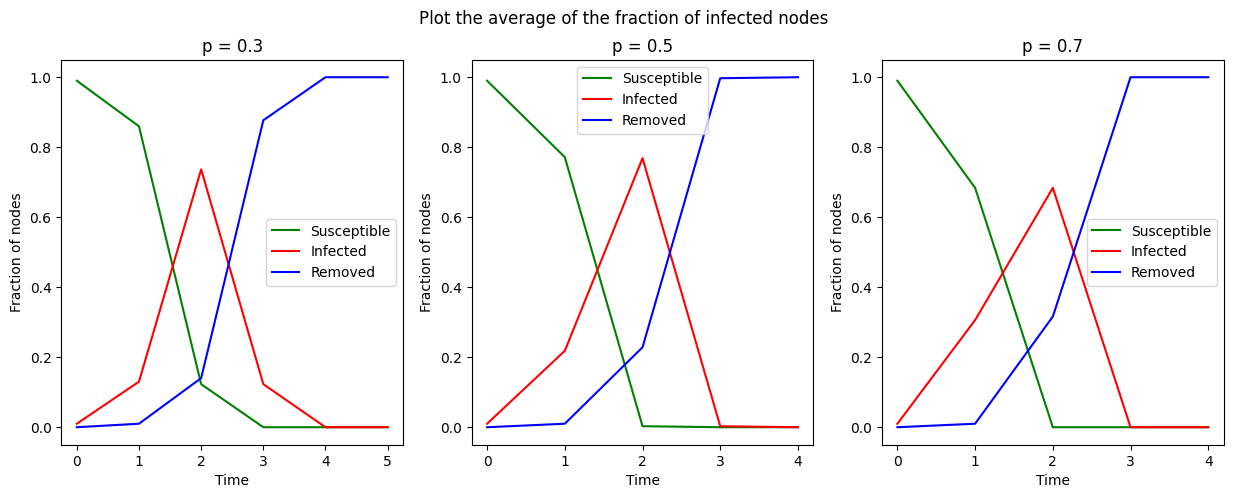

In [314]:
numb_nodes = 100
p = 0.5
G_rand = nx.erdos_renyi_graph(numb_nodes, p)

frac_time = fraction_time(G_rand, q, N)
plot_frac(frac_time, q)

### Watts–Strogatz graph

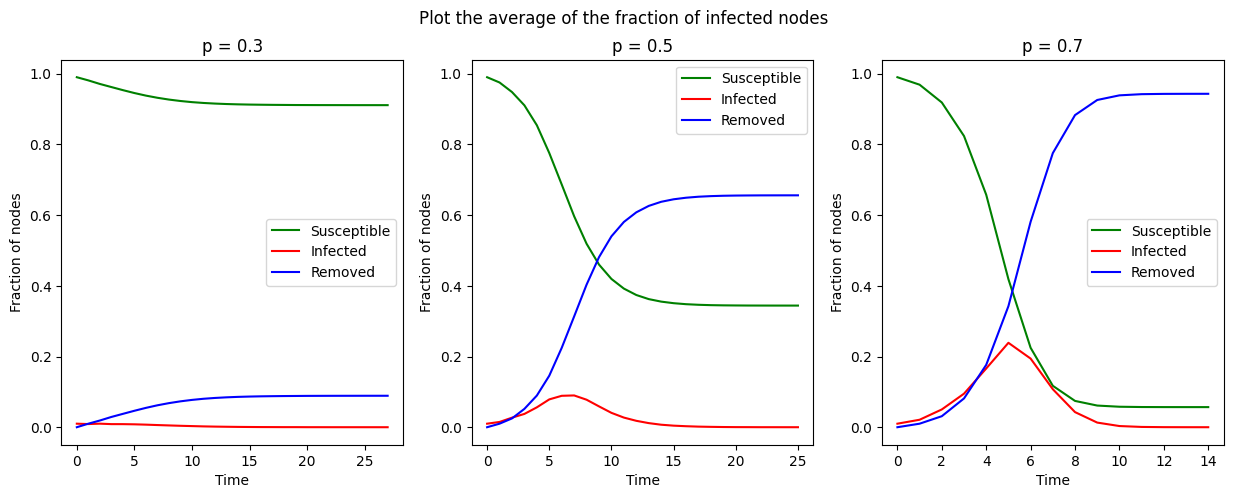

In [315]:
numb_nodes = 100
k = 4
p = 0.7
G_ws = nx.watts_strogatz_graph(numb_nodes, k, p)

frac_time = fraction_time(G_ws, q, N)
plot_frac(frac_time, q)

### Barabási–Albert graph

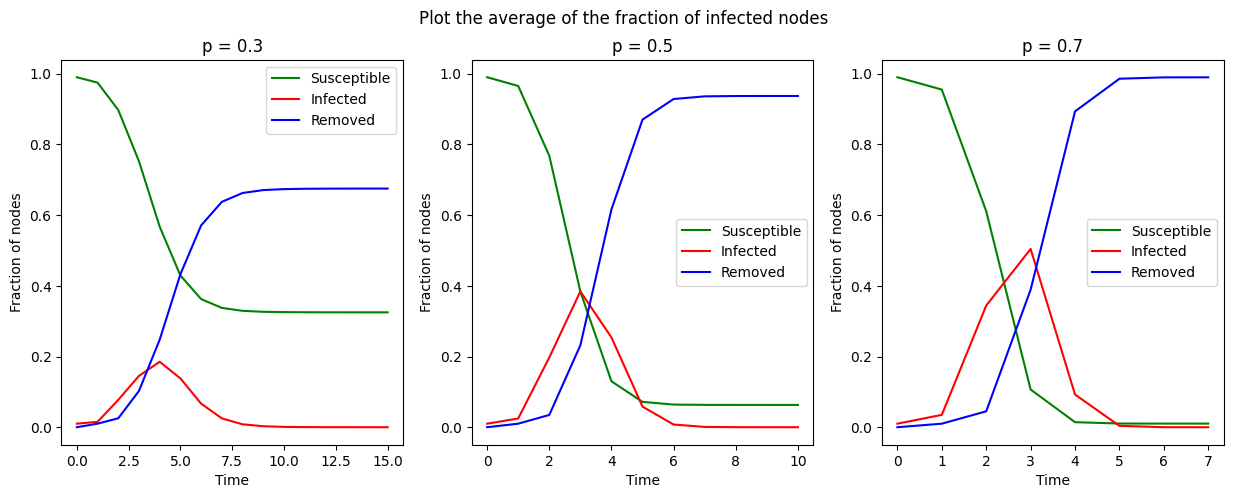

In [316]:
numb_nodes = 100
m = 4
G_ba = nx.barabasi_albert_graph(numb_nodes, m)

frac_time = fraction_time(G_ba, q, N)
plot_frac(frac_time, q)

## c. Compare with ODE model

## d, e. Simulation with 20 different value of p. Conclusion

In [383]:
numb = 25
step = 1 / (numb - 1)
p_min = 0
p_max = 1 + step/10
q = np.arange(p_min, p_max, step)

N = 1000

In [411]:
def total_prop_inf(G, p, N):
    all_prop = []
    for q in p:
        prop = 0
        for i in range(N):
            res = sir_netw(G, q)
            infected = np.array(res)[:,1]
            prop += np.sum(infected) / len(G.nodes)
        prop /= N
        all_prop.append(prop)
    return all_prop

In [412]:
def plot_total_prop_inf(all_prop, p):
    fig, ax = plt.subplots(figsize = (6, 4))
    fig.suptitle("Plot of the total propotion of the network that becomes infected")
    ax.plot(p, all_prop)
    ax.set(xlabel = 'p', ylabel = 'Propotion')
    ax.set_xlim(-0.01, 1.01)
    plt.grid()
    plt.show()

### 2D lattice graph

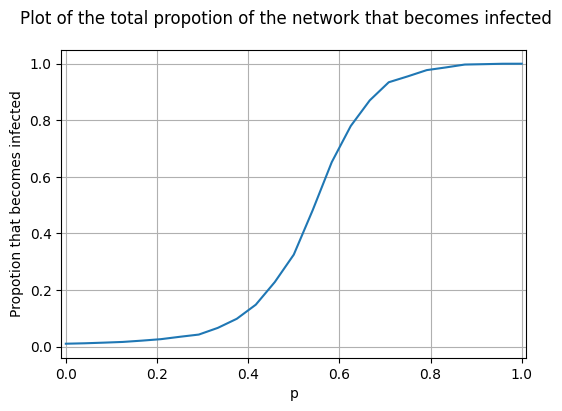

In [413]:
a = 10
b = 10
G_2d_lat = nx.grid_2d_graph(a, b)

tpi = total_prop_inf(G_2d_lat, q, N)
plot_total_prop_inf(tpi, q)

### Random graph

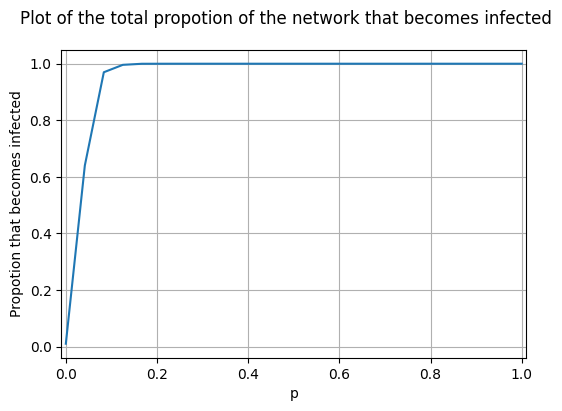

In [419]:
numb_nodes = 100
p = 0.5
G_rand = nx.erdos_renyi_graph(numb_nodes, p)

tpi = total_prop_inf(G_rand, q, N)
plot_total_prop_inf(tpi, q)

### Watts–Strogatz graph

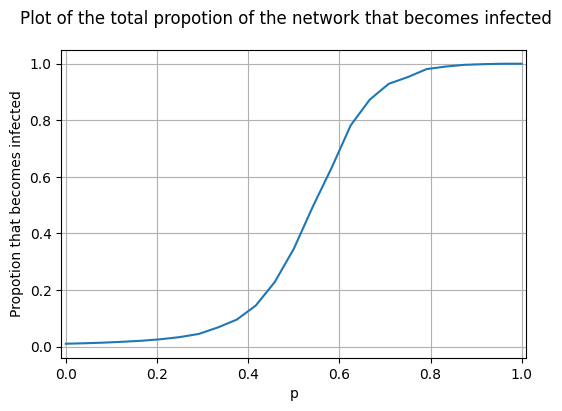

In [420]:
numb_nodes = 100
k = 4
p = 0.7
G_ws = nx.watts_strogatz_graph(numb_nodes, k, p)

tpi = total_prop_inf(G_2d_lat, q, N)
plot_total_prop_inf(tpi, q)

### Barabási–Albert graph

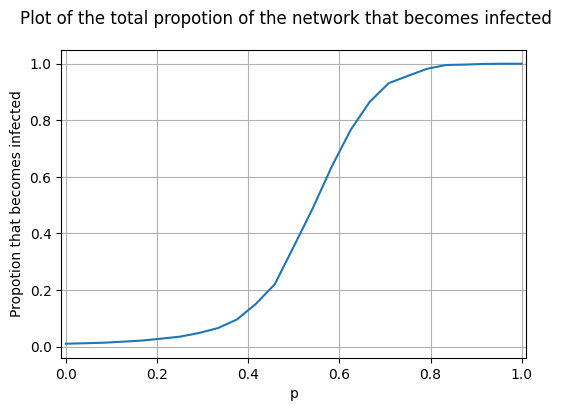

In [421]:
numb_nodes = 100
m = 4
G_ba = nx.barabasi_albert_graph(numb_nodes, m)

tpi = total_prop_inf(G_2d_lat, q, N)
plot_total_prop_inf(tpi, q)

In [424]:
def time_clear(G, p, N):
    all_time = []
    for q in p:
        time = 0
        for i in range(N):
            res = sir_netw(G, q)
            time += len(res)
        time /= N
        all_time.append(time)
    return all_time

In [425]:
def plot_time_clear(all_time, p):
    fig, ax = plt.subplots(figsize = (6, 4))
    fig.suptitle("Plot of the time to clear infection")
    ax.plot(p, all_time)
    ax.set(xlabel = 'p', ylabel = 'Time')
    ax.set_xlim(-0.01, 1.01)
    plt.grid()
    plt.show()

### 2D lattice graph

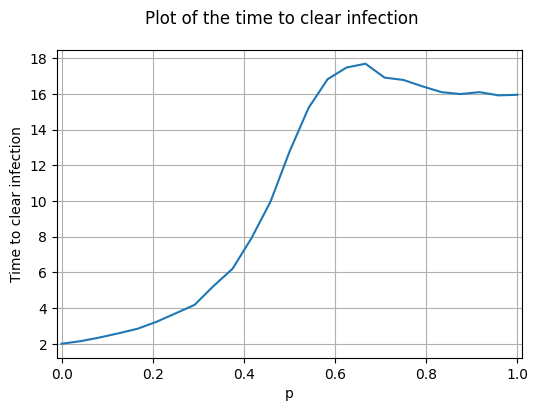

In [426]:
a = 10
b = 10
G_2d_lat = nx.grid_2d_graph(a, b)

tc = time_clear(G_2d_lat, q, N)
plot_time_clear(tc, q)

### Random graph

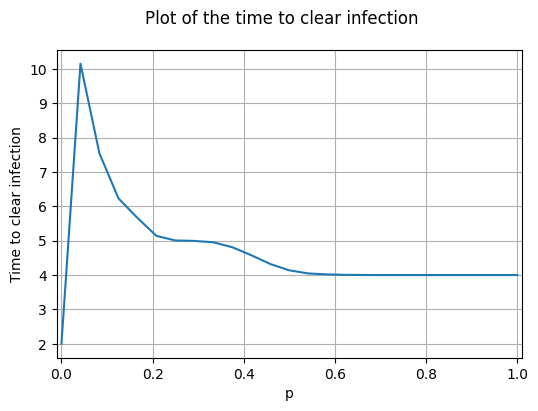

In [427]:
numb_nodes = 100
p = 0.5
G_rand = nx.erdos_renyi_graph(numb_nodes, p)

tc = time_clear(G_rand, q, N)
plot_time_clear(tc, q)

### Watts–Strogatz graph

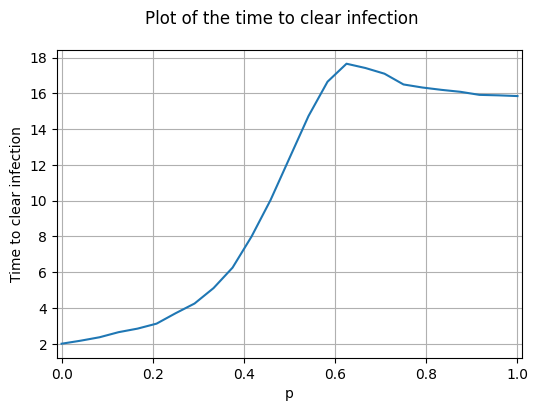

In [428]:
numb_nodes = 100
k = 4
p = 0.7
G_ws = nx.watts_strogatz_graph(numb_nodes, k, p)

tc = time_clear(G_2d_lat, q, N)
plot_time_clear(tc, q)

### Barabási–Albert graph

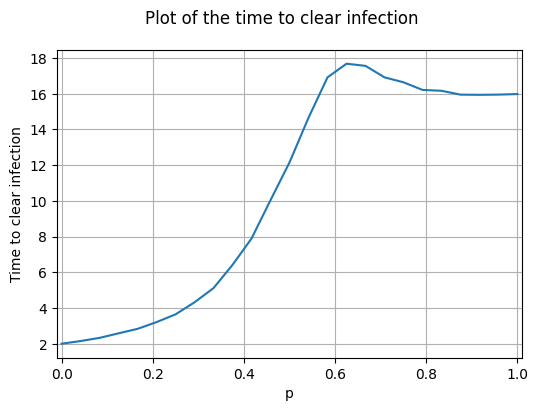

In [429]:
numb_nodes = 100
m = 4
G_ba = nx.barabasi_albert_graph(numb_nodes, m)

tc = time_clear(G_2d_lat, q, N)
plot_time_clear(tc, q)

In [463]:
def time_largest(G, p, N):
    all_time = []
    for q in p:
        time = 0
        for i in range(N):
            res = sir_netw(G, q)
            inf = np.array(res)[:,1]
            time += np.argmax(inf)
        time /= N
        all_time.append(time)
    return all_time

In [464]:
def plot_time_largest(all_time, p):
    fig, ax = plt.subplots(figsize = (6, 4))
    fig.suptitle("Plot of the time to the largest number of infected nodes")
    ax.plot(p, all_time)
    ax.set(xlabel = 'p', ylabel = 'Time')
    ax.set_xlim(-0.01, 1.01)
    plt.grid()
    plt.show()

### 2D lattice graph

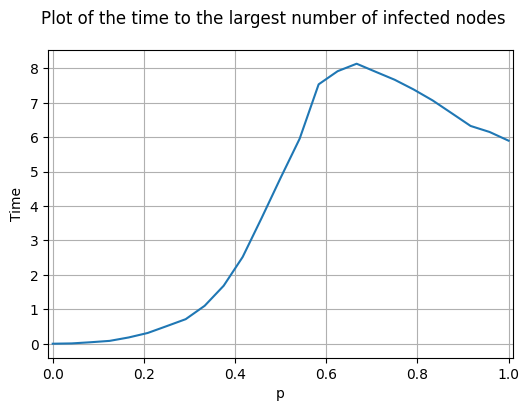

In [465]:
a = 10
b = 10
G_2d_lat = nx.grid_2d_graph(a, b)

tl = time_largest(G_2d_lat, q, N)
plot_time_largest(tl, q)

### Random graph

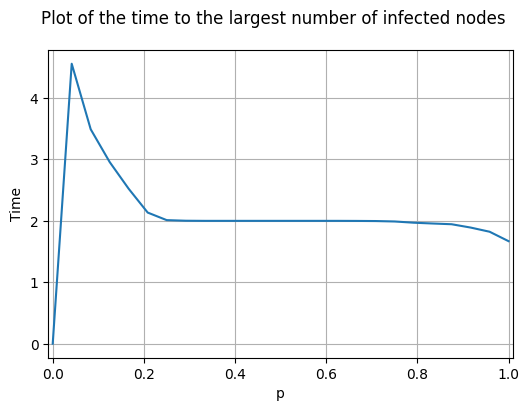

In [466]:
numb_nodes = 100
p = 0.5
G_rand = nx.erdos_renyi_graph(numb_nodes, p)

tl = time_largest(G_rand, q, N)
plot_time_largest(tl, q)

### Watts–Strogatz graph

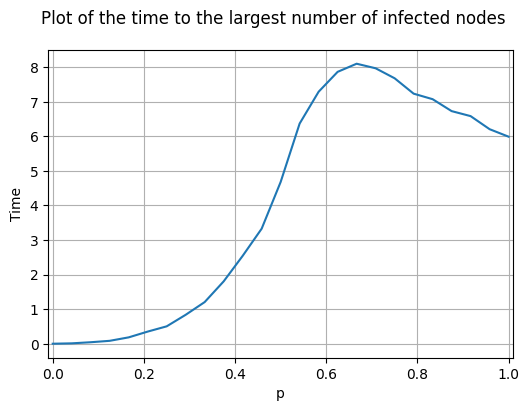

In [467]:
numb_nodes = 100
k = 4
p = 0.7
G_ws = nx.watts_strogatz_graph(numb_nodes, k, p)

tl = time_largest(G_2d_lat, q, N)
plot_time_largest(tl, q)

### Barabási–Albert graph

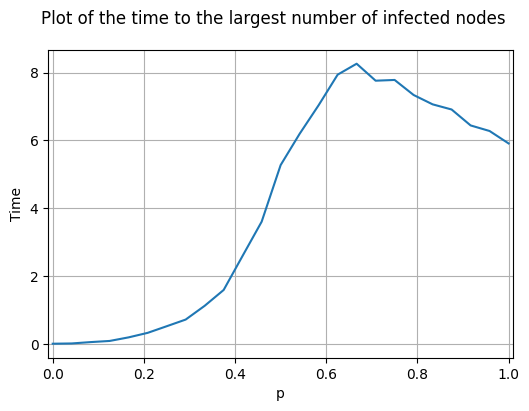

In [468]:
numb_nodes = 100
m = 4
G_ba = nx.barabasi_albert_graph(numb_nodes, m)

tl = time_largest(G_2d_lat, q, N)
plot_time_largest(tl, q)

## f. Visualizing a single run of the infection spreading

In [492]:
def create_gif(G, result, name):
    frames = []
    n = len(result)

    for i in range(n):
        color_map = []
        nodes = result[i][-1]
        for j in nodes:
            if nodes[j]["state"] == "S":
                color_map.append('green')
            elif nodes[j]["state"] == "I":
                color_map.append('red')
            else:
                color_map.append('blue')

        plt.figure(figsize = (8, 8))
        if name == "2d_lat":
            nx.draw_spectral(G, with_labels = True, node_color = color_map)
        else:
            nx.draw_kamada_kawai(G, with_labels = True, node_color = color_map)
        plt.savefig(f'{name}_{i}.png')
        frames.append(Image.open(f'{name}_{i}.png'))
        plt.close()

    frames.append(Image.open(f'{name}_{n-1}.png'))
    frames.append(Image.open(f'{name}_{n-1}.png'))

    frames[0].save(f"{name}.gif", format = "GIF", append_images = frames[1:], optimize = True, save_all = True, duration = n*90, loop = 0)


### 2D lattice graph

In [20]:
a = 5
b = 6
G_2d_lat = nx.grid_2d_graph(a, b)

q = 0.3
result_2d_lat = sir_netw(G_2d_lat, q, with_nodes = True)

create_gif(G_2d_lat, result_2d_lat, "2d_lat")

### Random graph

In [21]:
numb_nodes = 30
p = 0.5
G_rand = nx.erdos_renyi_graph(numb_nodes, p)

q = 0.3
result_rand = sir_netw(G_rand, q, with_nodes = True)

create_gif(G_rand, result_rand, "rand")

### Watts–Strogatz graph

In [22]:
numb_nodes = 30
k = 4
p = 0.7
G_ws = nx.watts_strogatz_graph(numb_nodes, k, p)

q = 0.3
result_ws = sir_netw(G_ws, q, with_nodes = True)

create_gif(G_ws, result_ws, "ws")

### Barabási–Albert graph

In [23]:
numb_nodes = 30
m = 4
G_ba = nx.barabasi_albert_graph(numb_nodes, m)

q = 0.3
result_ba = sir_netw(G_ba, q, with_nodes = True)

create_gif(G_ba, result_ba, "ba")

# 3. SIR model on a network (continue)

In [475]:
def sir_netw_new(G, p, origin = None, with_nodes = False):
    """
#    Single run of the SIR model on network.
    """
    
    N = len(G)
    infected = []
    
    # initialize nodes
    for node in G.nodes():
        G.nodes[node]["state"] = "S" # all healthy at the beginning

    #inject the 'zero' patient randomly if we do not have given one
    if origin == None:
        node = random.choice(list(G.nodes))
        G.nodes[node]["state"] = "I"
#         infected = [node]
    else:
        G.nodes[origin]["state"] = "I"
#         infected = [origin]
    
    results = [[N - 1, 1, 0, G.copy().nodes]]
    
    #time loop as many times as the number of nodes
    for i in range(N):
#     while results[-1][1] != 0:
#         new_infected = []
        ns = results[-1][0]
        ni = results[-1][1]
        nr = results[-1][2]
        
        node = random.choice(list(G.nodes))
        if G.nodes[node]["state"] == "I":
            for neigh in G.neighbors(node):
                if G.nodes[neigh]["state"] == "S":
                    q = random.random()
                    if q < p:
                        G.nodes[neigh]["state"] = "I"
#                         new_infected.append(neigh)
                        ns -= 1
                        ni += 1
            G.nodes[node]["state"] = "R"
            ni -= 1
            nr += 1
        if with_nodes:
            results.append([ns, ni, nr, G.copy().nodes])
        else:
            results.append([ns, ni, nr])
#         infected = new_infected
    return results

## a. Simulate the model on graph with 100 nodes

I chose probability $p = 0.3$

In [472]:
q = 0.3

### 2D lattice graph

In [498]:
a = 10
b = 10
G_2d_lat = nx.grid_2d_graph(a, b)

result_2d_lat = sir_netw_new(G_2d_lat, q)
last_res = result_2d_lat[-1]
print(f"Number of susceptible: {last_res[0]}, infected: {last_res[1]}, removed: {last_res[2]}")

Number of susceptible: 98, infected: 1, removed: 1


### Random graph

In [499]:
numb_nodes = 100
p = 0.5
G_rand = nx.erdos_renyi_graph(numb_nodes, p)

result_rand = sir_netw_new(G_rand, q)
last_res = result_rand[-1]
print(f"Number of susceptible: {last_res[0]}, infected: {last_res[1]}, removed: {last_res[2]}")

Number of susceptible: 99, infected: 1, removed: 0


### Watts–Strogatz graph

In [500]:
numb_nodes = 100
k = 4
p = 0.7
G_ws = nx.watts_strogatz_graph(numb_nodes, k, p)

result_ws = sir_netw_new(G_ws, q)
last_res = result_ws[-1]
print(f"Number of susceptible: {last_res[0]}, infected: {last_res[1]}, removed: {last_res[2]}")

Number of susceptible: 95, infected: 3, removed: 2


### Barabási–Albert graph

In [501]:
numb_nodes = 100
m = 4
G_ba = nx.barabasi_albert_graph(numb_nodes, m)

q = 0.3
result_ba = sir_netw_new(G_ba, q)
last_res = result_ba[-1]
print(f"Number of susceptible: {last_res[0]}, infected: {last_res[1]}, removed: {last_res[2]}")

Number of susceptible: 82, infected: 11, removed: 7


On the final outcome of the model can be infected nodes. It is difficult to choose randomly the first infected node.